# Language-to-Language Translation Model Training

This notebook demonstrates how to train a sequence-to-sequence translation model using Keras and TensorFlow, with GPU support if available.


In [3]:
# GPU Setup and Library Imports
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

from numpy import array, argmax
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Num GPUs Available: 0


array([[<Axes: title={'center': 'eng'}>, <Axes: title={'center': 'sec'}>]],
      dtype=object)

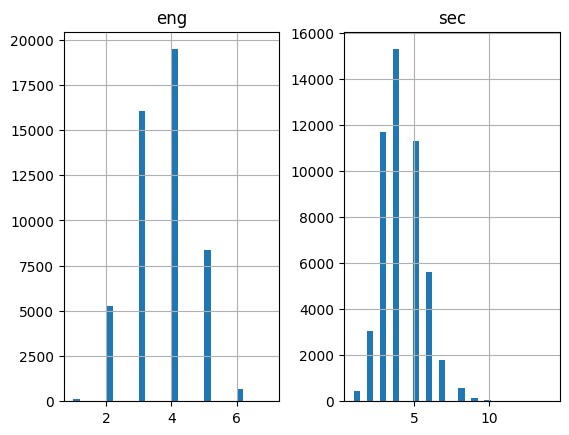

In [4]:
# Data Loading and Preprocessing

def read_text(filename):
    file = open(filename, mode='rt', encoding='utf-8')
    text = file.read()
    file.close()
    return text

def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

data = read_text(r"E:\Data Sets\bilingual-sentence-pairs\fra.txt")
sec_eng = to_lines(data)
sec_eng = array(sec_eng)
sec_eng = sec_eng[:50000,:]

for i in range(len(sec_eng)):
    sec_eng[i,0] = sec_eng[i,0].lower()
    sec_eng[i,1] = sec_eng[i,1].lower()

eng_l = []
sec_l = []
for i in sec_eng[:,0]:
    eng_l.append(len(i.split()))
for i in sec_eng[:,1]:
    sec_l.append(len(i.split()))
length_df = pd.DataFrame({'eng':eng_l, 'sec':sec_l})
length_df.hist(bins = 30)
# plt.show()

In [5]:
# Tokenization and Sequence Encoding

def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

eng_tokenizer = tokenization(sec_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

sec_tokenizer = tokenization(sec_eng[:, 1])
sec_vocab_size = len(sec_tokenizer.word_index) + 1
sec_length = 8
print('Secondary Vocabulary Size: %d' % sec_vocab_size)

def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

train, test = train_test_split(sec_eng, test_size=0.2, random_state = 12)
trainX = encode_sequences(sec_tokenizer, sec_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
# prepare validation data
testX = encode_sequences(sec_tokenizer, sec_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

English Vocabulary Size: 6044
Secondary Vocabulary Size: 12884
Secondary Vocabulary Size: 12884


In [ ]:
# Model Definition and Compilation

def define_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

from keras.optimizers import Adam
model = define_model(sec_vocab_size, eng_vocab_size, sec_length, eng_length, 1024)
rms = optimizers.RMSprop(learning_rate=0.005)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

c:\Users\sudha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Model Training and Checkpointing

from keras.callbacks import ModelCheckpoint
filename = 'savepoints/model_savepoint.keras'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=150, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose='auto')

Epoch 1/150


In [ ]:
# Training Loss Visualization
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
# plt.show()

In [ ]:
# Model Evaluation and Prediction
model = load_model('savepoints/model_savepoint.keras')
pred_probs = model.predict(testX.reshape((testX.shape[0], testX.shape[1])))
preds = argmax(pred_probs, axis=-1)

def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t) 
    preds_text.append(' '.join(temp))
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})
pred_df.head(5)